In this notebook, we will write a short animation to solve a fun application of physics to image compression.
Our goal is to compress a Mona-Lisa image into a series of numbers, based on the eigenmodes of an acoustic plate.

The idea is based on a talk at the ASA Spring 2024 meeting conference in Ottawa given by [Tre DiPassio](https://www.tredipassio.com/).

First, let’s start with some theory.

# The eigenmodes of an acoustic plate

In the context of acoustics, the Helmholtz equation can be used to represent the propagation of an acoustic wave. In two dimensions, the equation reads:

$$
\frac{\omega ^2}{c^2} p + \left(\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2}\right) = 0
$$

Assuming Neumann boundary conditions, we can find solutions to this equation as eigenpairs $(\omega_{mn}, p_{mn}(x, y)), (m,n) \in \mathbb{N}$:

$$
\left \lbrace
\begin{aligned}
\omega_{mn} = c^2\left((\frac{m\pi}{l_x})^2 + (\frac{n\pi}{l_y})^2\right)\\
p_{mn} = \cos(\frac{m \pi}{l_x} x) \cos(\frac{n \pi}{l_y} y) 
\end{aligned}
\right.
$$

Why is this interesting? Because the modes $p_{mn}$ that are obtained are orthogonal and can thus easily be used in a fun way to decompose any image as a sum of modes.

In particular, if we have a image $I(x, y)$, we can represent it as a sum of $I(x, y) = \sum_i w_i p_{m(i)n(i)}$, where $w_i$ is the weight corresponding to $p_{m(i)n(i)}$. 

Let’s apply this formula to decompose the Mona-Lisa into modes. But before we dive in, let’s just plot some of these modes.

# Plotting modes

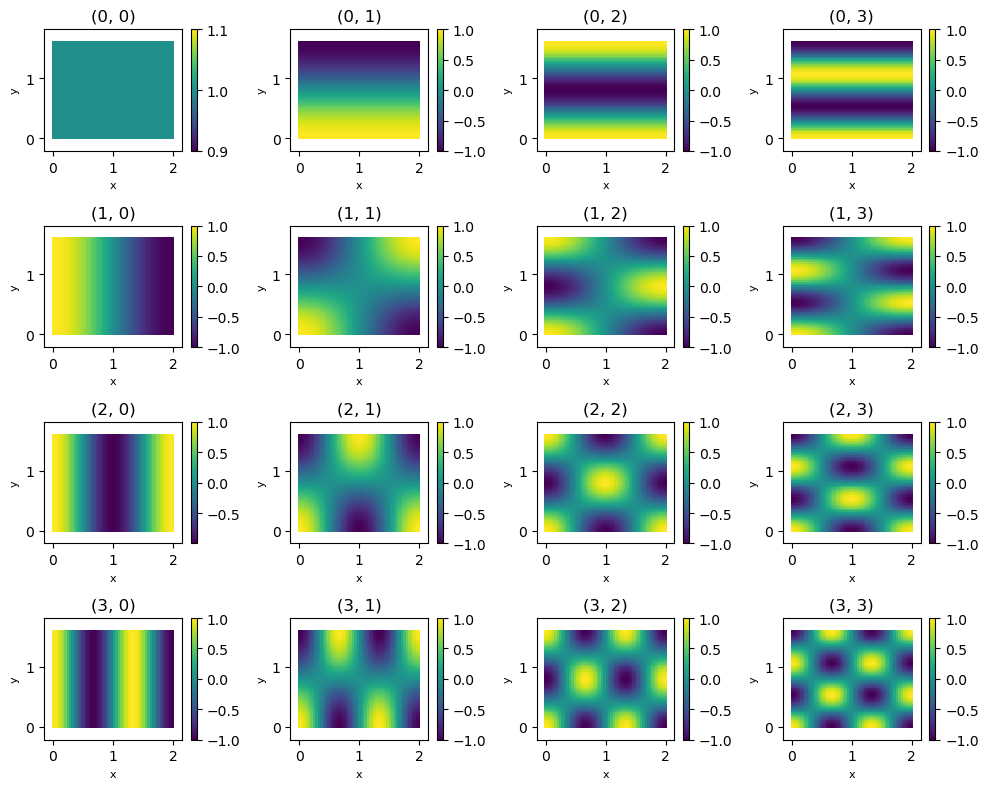

In [79]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

l_x = 2.
l_y = 1.6
c_squared = 1.

X, Y = np.meshgrid(np.linspace(0, l_x, num=50), np.linspace(0, l_y, num=51))


def eigenmode_analytical_solution(m, n, l_x, l_y, X, Y):
    """Returns mode (m, n) evaluated on X, Y grid."""
    return np.cos(m * np.pi / l_x * X) * np.cos(n * np.pi / l_y * Y)


def pulsation_analytical_solution(m, n, c_squared, l_x, l_y):
    """Returns omega associated to (m, n) mode."""
    k_x = m * np.pi / l_x
    k_y = n * np.pi / l_y
    omega_squared = c_squared * (k_x**2 + k_y**2)
    return np.sqrt(omega_squared)

def eigenmode(m, n):
    return eigenmode_analytical_solution(m, n, l_x, l_y, X, Y)

def pulsation(m, n):
    return pulsation_analytical_solution(m, n, c_squared, l_x, l_y)

def get_first_N_mode_indices(N, factor=2):
    """Returns (m, n) indices for first N modes."""
    pulsations = [(n, m, pulsation(n, m)) for n, m in product(range(factor * N), range(factor * N))]
    sorted_pulsations = sorted(pulsations, key=lambda item: item[2])    
    return [(a, b) for a, b, c in sorted_pulsations[:N]]

# plotting
nrows = 4
ncols = 4
fig, axes  = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 8))
for row in range(nrows):
    for col in range(ncols):
        m = axes[row, col].pcolormesh(X, Y, eigenmode(row, col))
        plt.colorbar(m, ax=axes[row, col])
        axes[row, col].set_title(f"({row}, {col})")
        axes[row, col].set_xlabel('x', fontsize=8)
        axes[row, col].set_ylabel('y', fontsize=8)
        axes[row, col].axis('equal')
plt.tight_layout()

# Decomposing an image


Now, the idea is to establish how an image is decomposed as such patterns. Let’s first download our test image.

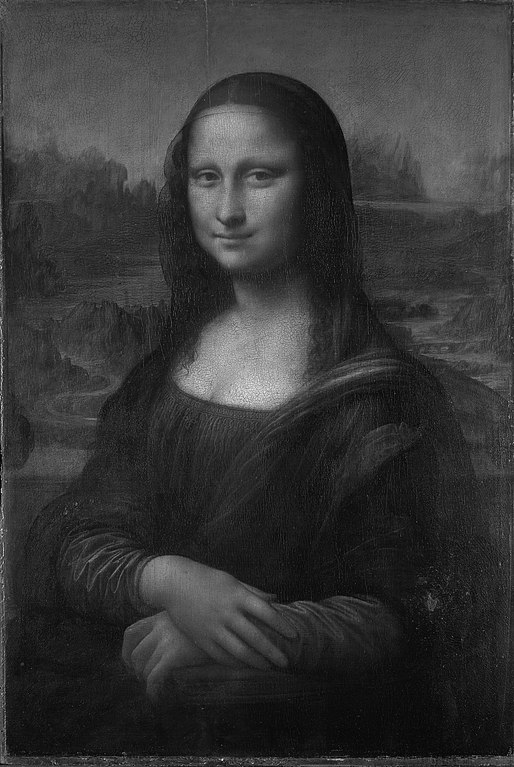

In [80]:
from PIL import Image
import requests
from io import BytesIO

url = "https://upload.wikimedia.org/wikipedia/commons/thumb/f/f9/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_natural_color.jpg/514px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_natural_color.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

img.convert('L')



Let’s turn this RGB image into a numpy array.

In [81]:
img_gray = np.array(img.convert('L'))

img_gray.shape, img_gray.min(), img_gray.max()

((767, 514), 0, 254)

Now, let’s define our modes by setting $l_x$ and $l_y$ equal to the image dimensions, build a grid and an ordered set of basis functions as a sequence instead of $m, n$ pairs.

In [82]:
l_x = img_gray.shape[1]
l_y = img_gray.shape[0]
c_squared = 1.

X, Y = np.meshgrid(np.linspace(0, l_x, num=l_x), np.linspace(0, l_y, num=l_y))


def eigenmode_analytical_solution(m, n, l_x, l_y, X, Y):
    """Returns mode (m, n) evaluated on X, Y grid."""
    return np.cos(m * np.pi / l_x * X) * np.cos(n * np.pi / l_y * Y)


def pulsation_analytical_solution(m, n, c_squared, l_x, l_y):
    """Returns omega associated to (m, n) mode."""
    k_x = m * np.pi / l_x
    k_y = n * np.pi / l_y
    omega_squared = c_squared * (k_x**2 + k_y**2)
    return np.sqrt(omega_squared)

def eigenmode(m, n):
    return eigenmode_analytical_solution(m, n, l_x, l_y, X, Y)

def pulsation(m, n):
    return pulsation_analytical_solution(m, n, c_squared, l_x, l_y)

def get_first_N_mode_indices(N, factor=2):
    """Returns (m, n) indices for first N modes."""
    pulsations = [(n, m, pulsation(n, m)) for n, m in product(range(factor * N), range(factor * N))]
    sorted_pulsations = sorted(pulsations, key=lambda item: item[2])    
    return [(a, b) for a, b, c in sorted_pulsations[:N]]


In [83]:
basis = get_first_N_mode_indices(1000)

basis[:20]

[(0, 0),
 (0, 1),
 (1, 0),
 (1, 1),
 (0, 2),
 (1, 2),
 (2, 0),
 (0, 3),
 (2, 1),
 (1, 3),
 (2, 2),
 (0, 4),
 (2, 3),
 (1, 4),
 (3, 0),
 (3, 1),
 (3, 2),
 (2, 4),
 (0, 5),
 (1, 5)]

We can now build our index by looping over the basis function and computing the weights of each mode. How is this done? Well, if the image has values defined in discrete points $I(i, j)$, then a standard way to define an approximate dot product is to compute a sum 

$$
\iint_S I(x, y) p_{mn}(x, y) dS \approx \sum_{i, j} I(i, j) P_{mn}(i, j)
$$

with that said, the weights $w_i$ are computed as 

$$
w_i = \frac{\sum_{i, j} I(i, j) P_{mn}(i, j)}{\sum_{i, j} P_{mn}(i, j) P_{mn}(i, j)}
$$

In [84]:
from tqdm.notebook import tqdm

def dot_product(img, pmn):
    return (img * pmn).sum()

weights = []
for m, n in tqdm(basis):
    pmn = eigenmode(m, n)
    w = dot_product(img_gray, pmn) / dot_product(pmn, pmn)
    weights.append(w)

  0%|          | 0/1000 [00:00<?, ?it/s]

Now, let’s build the reconstruction of the image.

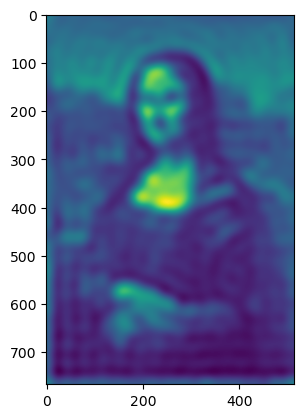

In [85]:
reconstructed = sum(eigenmode(m, n) * w for (m,n), w in zip(basis, weights))
plt.imshow(reconstructed)

Ok, not bad, we’re starting to see a resemblance. 

# An animation

Let’s see if we can animate the whole process to get an interesting visualization.

In [86]:
import matplotlib.animation as manim
from IPython.display import HTML

fig, ax = plt.subplots()
reconstructed = np.zeros_like(img_gray, dtype=float)
current_index = 0
imshow = ax.imshow(reconstructed, cmap='gray')
ax.axis('off')

nframes = 1000
basis = get_first_N_mode_indices(nframes)

def update(frame):
    global reconstructed
    m, n = basis[frame]
    pmn = eigenmode(m, n)
    w = dot_product(img_gray, pmn) / dot_product(pmn, pmn)
    reconstructed += w * pmn
    imshow.set_data(reconstructed)
    imshow.set_clim(reconstructed.min(), reconstructed.max())
    ax.set_title(f"used {frame} basis functions")
    return imshow,

ani = manim.FuncAnimation(fig, update, frames=np.arange(nframes),
                    init_func=None, blit=True, interval=25)
plt.close(fig)
HTML(ani.to_html5_video())

As you can see in the animation above, the reconstruction still lacks a lot of details even using 400 basis functions. In fact, it’s an interesting question to see how many modes on needs to use before the reconstruction is good enough. I won’t go into that sort of details here, and just leave it at this fun animation.


*This post was entirely written using the Jupyter Notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20240603_modes_image_projection.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20240603_modes_image_projection.ipynb).*